In [1]:
import pickle as pkl

import numpy as np

import matplotlib
matplotlib.rcParams.update({'font.size': 6})
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec

savefig = False

base_pathstem='/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/'
paper1_savepath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/Paper1/plots/'

In [2]:
# constants
from astropy.constants import e, c, m_e
import astropy.units as u
from scipy.special import gamma
e = e.esu.value * u.cm**1.5 * u.g**0.5 / u.s

#constants
e = e.cgs.value
c = c.cgs.value
m_e = m_e.cgs.value
#units
cm = 1.0
gram = 1.0
sec = 1.0
Hz = 1.0
kpc = (1.*u.kpc).cgs.value
Msun = (1.*u.Msun).cgs.value
erg = (1.*u.erg).cgs.value
def get_cgs (x): return x
def get_cgs_value (x): return x
    
# simulation units
# anchor points
simu_rho = get_cgs(10**(-15) * gram/cm**3)
simu_t = get_cgs(1.*sec)
simu_len = get_cgs(c*simu_t)
# derivative units
simu_mass = get_cgs(simu_rho * simu_len**3)
simu_en = simu_mass * get_cgs(c)**2 # erg
simu_press = simu_en / simu_len**3 # erg / cm^3
simu_B = np.sqrt(2.*simu_press) # sqrt( erg / cm^3 )
simu_B_8piCorr = np.sqrt(8.*np.pi*simu_press) # sqrt( erg / cm^3 )

In [3]:
sim2phys = {
    'Time':simu_t, # sec
    'x1f':simu_len, # cm
    'x2f':simu_len, # cm
    'x3f':simu_len, # cm
    'x1v':simu_len, # cm
    'x2v':simu_len, # cm
    'x3v':simu_len, # cm
    'rho':simu_mass/simu_len**3, # g / cm^3
    'press':simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'vel1': 1.0, # c
    'vel2': 1.0, # c
    'vel3': 1.0, # c
    'vel_tot': 1.0, # c
    'Bcc1': simu_B, # sqrt(erg / cm^3)
    'Bcc2': simu_B, # sqrt(erg / cm^3)
    'Bcc3': simu_B, # sqrt(erg / cm^3)
    'Bcc_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_0': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_1': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_2': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_3': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot_vsZ': simu_B, # sqrt(erg / cm^3)
    'enthalpy': simu_mass * (simu_len/simu_t)**2 / simu_mass, # erg/g
    'internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'j_nu': 1.0, # erg / cm**3
    'j_nu_vsZ': 1.0, # erg / cm**3
    'j_over_alpha_nu': 1.0, # erg / cm**2
    'j_over_alpha_nu_vsZ': 1.0, # erg / cm**2
    'flux_density': 1.0, # erg/(cm**2*sec) / cm**2
    'flux_density_vsZ': 1.0, # erg/(cm**2*sec) / cm**2
    'spectrum': (1.0, 1.0), # (Hz, erg / (s cm**2 Hz) / cm**2)
    'ddt_internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
    'ddt_internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
}

In [4]:
def alignment_masks (times1, times2):
    '''Produces masks for two datasets
    where their times are aligned.'''
    return np.array([elem in times2 for elem in times1]), np.array([elem in times1 for elem in times2])

def mask_after_gap (times, dt):
    '''Produces a mask that turns off the first snapshot after a gap,
    as well as duplicate snapshots'''
    return np.array([True,] + [((e2 - e1 < 1.2*dt) and (e2 - e1 > 0.8*dt)) for e1,e2 in zip(times[:-1], times[1:])])

In [88]:
class Dataset:
    
    def __init__ (
        self,
        name,
        label='',
        amplitudes=[1,2,5,10,20,50,75,100],
        shell_widths=[]
    ):
        self.name=name
        self.pathstem = base_pathstem + name + '/'
        if label == '':
            self.label=self.name
        else:
            self.label=label
        
        self.amplitudes=amplitudes
        self.n_ampl = len(self.amplitudes)
        self.colors = {self.amplitudes[i]:mplcm.jet(1.0*i/self.n_ampl) for i in range(self.n_ampl)}
        self.linestyles = {0:':', 1:'-'}
        
        self.shell_widths=shell_widths
        
    def plot_Fsyn_vs_time (self, ax, legend=False, legend_kwargs={}, ylabels=True, title=False):
        
        for ampl in self.amplitudes:
            for corr in [1,]:# [0,1]:
                with open(self.pathstem+'prod1_corr_ampl/history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
                    data = pkl.load(f)

                if corr == 0:
                    ax.plot(
                        data['times'] * sim2phys['Time'],
                        data['flux_density'] * sim2phys['flux_density'],
                        color=self.colors[ampl],
                        ls=self.linestyles[corr]
                    )
                else:
                    ax.plot(
                        data['times'] * sim2phys['Time'],
                        data['flux_density'] * sim2phys['flux_density'],
                        color=self.colors[ampl],
                        ls=self.linestyles[corr],
                        label=('ampl = %i' % ampl)
                    )

                del data
        ax.set_yscale('log')
        if legend:
            ax.legend(**legend_kwargs)
        ax.set_ylim(3.0e-32, 9.0e-29)
        ax.set_xlabel('Time [s]')
        ax.grid(True)
        if ylabels:
            ax.set_ylabel('$dF_{\\rm syn}/dS$ [${\\rm erg}/({\\rm cm}^5{\\rm s})$]')
        else:
            ax.axes.yaxis.set_ticklabels([])
        if title:
            ax.set_title(self.label)
        #plt.text(0.8,0.94, '(b)', transform=plt.gca().transAxes)
        
    def plot_FsynRelDiff_vs_ampl (self, ax, ylabels=True):
        '''Plot the integrated net synchrotron flux difference'''
        
        synchro_diff_tot = {}
        synchro_mean_tot = {}
        for ampl in self.amplitudes:
            data = {}
            for corr in [0,1]:
                with open(self.pathstem+'prod1_corr_ampl/history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
                    data[corr] = pkl.load(f)

            # align timestamps
            mask0, mask1 = alignment_masks(data[0]['times'], data[1]['times'])

            total_emission = 0.5 * (data[1]['flux_density'][mask1] + data[0]['flux_density'][mask0])
            total_emission = 0.5 * (total_emission[1:] + total_emission[:-1])

            difference = data[1]['flux_density'][mask1] - data[0]['flux_density'][mask0]
            difference = 0.5 * (difference[1:] + difference[:-1])

            dt = data[0]['times'][1] - data[0]['times'][0]

            synchro_diff_tot[ampl] = np.sum(difference*dt)
            synchro_mean_tot[ampl] = np.sum(total_emission*dt)

            del data

        # plot
        ax.plot(synchro_diff_tot.keys(), np.array(list(synchro_diff_tot.values())) / np.array(list(synchro_mean_tot.values())))
        ax.set_xlabel('Corr. Amplitude [%]')
        ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0])
        if ylabels:
            ax.set_ylabel('$\\Delta F_{\\rm syn}/F_{\\rm syn}$')
            
    def plot_FsynRelDiff_vs_time (self, ax, legend=False, legend_kwargs={}, xlabels=True, ylabels=True, ampl_subset=[], title=False):
        
        if len(ampl_subset) == 0:
            ampl_subset = self.amplitudes
            colors = self.colors
        else:
            colors = {ampl_subset[i]:mplcm.jet(1.0*i/len(ampl_subset)) for i in range(len(ampl_subset))}
        
        #diffscale = {}
        for ampl in ampl_subset:
            data = {}
            for corr in [0,1]:
                with open(self.pathstem+'prod1_corr_ampl/history_corr%iampl%i.pkl' % (corr, ampl), 'rb') as f:
                    data[corr] = pkl.load(f)


            # align timestamps
            mask0, mask1 = alignment_masks(data[0]['times'], data[1]['times'])
            # calculate the difference and mean
            difference = data[1]['flux_density'][mask1] - data[0]['flux_density'][mask0]
            average = 0.5 * (data[1]['flux_density'][mask1] + data[0]['flux_density'][mask0])

            values = difference/average
            ax.plot(data[0]['times'][mask0], values, color=colors[ampl], ls=self.linestyles[corr], label=('ampl = %i' % ampl))
            #plt.scatter(data[0]['times'][mask0], values, color=colors[ampl], ls=linestyles[corr], label=('ampl = %i' % ampl), s=4)

            #mini, maxi = min(0., np.min(values)), np.max(values)
            #length = maxi - mini
            #mini, maxi = mini - 0.05*length, maxi + 0.05*length
            #diffscale[ampl] = [mini, maxi]

            del data

        if legend:
            ax.legend(**legend_kwargs)
        if xlabels:
            ax.set_xlabel('Time [s]')
        else:
            ax.axes.xaxis.set_ticklabels([])
        if ylabels:
            ax.set_ylabel('$\\Delta F_{\\rm syn}/F_{\\rm syn}$')
        if title:
            ax.text(0.025,0.75,self.label, transform=plt.gca().transAxes)

In [89]:
dataset_names = ['corrT1_dens', 'corrT2_press', 'corrT3_vel']
labels={
    'corrT1_dens':'Density corrugation',
    'corrT2_press':'Pressure corrugation',
    'corrT3_vel':'Velocity corrugation'
}
datasets = {name:Dataset(name, label=labels[name]) for name in dataset_names}

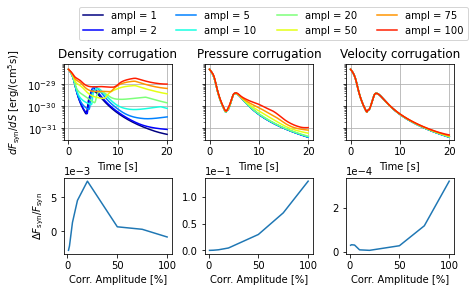

In [116]:
# Color coded Fsyn(t) as 3 panels for T1,2,3. In bottom panels show time-integrated relative Fsyn difference.

fig = plt.figure(figsize=(7,3.5))
gs = gridspec.GridSpec(2,3, hspace=0.5, wspace=0.3)

for i in range(3):
    dataset = datasets[dataset_names[i]]
    # plot synchrotron flux
    ax = plt.subplot(gs[0,i])
    dataset.plot_Fsyn_vs_time(ax,
        legend=(i==0),
        legend_kwargs={
            'ncol':4, 'bbox_to_anchor':(0.092,1.25)
        },
        ylabels=(i==0),
        title=True
    )
    
    # plot relative time-integrated synchrotron flux difference
    ax = plt.subplot(gs[1,i])
    dataset.plot_FsynRelDiff_vs_ampl(ax,
        ylabels=(i==0)
    )

if savefig:
    plt.subplots_adjust(top=0.775, right=0.99)
    plt.savefig(paper1_savepath + 'Fsyn_tot.png', format='png', dpi=600)
else:
    plt.show()
plt.close()

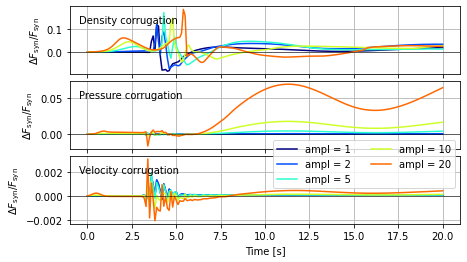

In [113]:
#  Fsyn diff / ampl: try color-coded all in one plot, one panel for T1,2,3.

fig = plt.figure(figsize=(7.,4.))
gs = gridspec.GridSpec(3,1, hspace=0.1)

for i in range(3):
    dataset = datasets[dataset_names[i]]
    
    ax = plt.subplot(gs[i,0])
    dataset.plot_FsynRelDiff_vs_time(
        ax,
        ampl_subset=[1,2,5,10,20],
        legend=(i==2),
        legend_kwargs={'ncol':2, 'loc':'upper right', 'bbox_to_anchor':(1.,1.3)},
        xlabels=(i==2),
        title=True
    )
    
    plt.grid()
    plt.axhline(0.,color='k', linewidth=0.5)
    
if savefig:
    plt.subplots_adjust(top=0.99, right=0.99, bottom=0.12)
    plt.savefig(paper1_savepath + 'Fsyn_relDiff.png', format='png', dpi=600)
else:
    plt.show()
plt.close()